<div class="alert alert-block alert-info"><center> <H1> Kaggle 2020 Survey: An Overview </center></div>

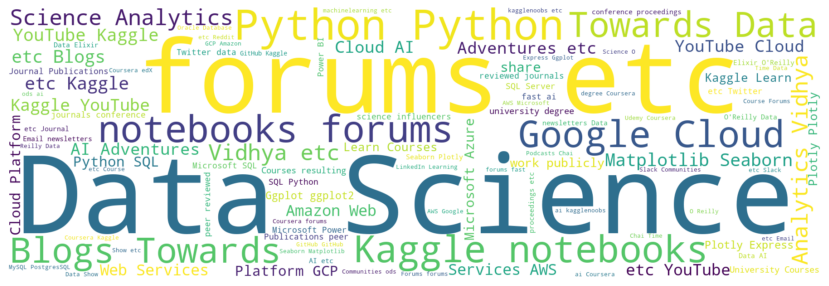

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from itertools import combinations
from collections import Counter
import warnings
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import wordcloud

warnings.filterwarnings("ignore")
sns.set_style('darkgrid')
sns.color_palette("rocket")
%matplotlib inline

pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

# Data Cleaning and Transformation

In [ ]:
df = pd.read_csv('../input/kaggle-survey-2020/kaggle_survey_2020_responses.csv')

questions = df.loc[:0]

multiple_options_questions = set()
multiple_options_questions_A_B = set()

for q in list(questions.filter(regex=("Q\d+_Part_\d+")).columns):
    multiple_options_questions.add(int(q.split("_")[0][1:]))
for q in list(questions.filter(regex=("Q\d+_A_Part_\d+")).columns):
    multiple_options_questions_A_B.add(int(q.split("_")[0][1:]))

def extract_question(row):
    row = list(row)
    return row[0].split("-")[0].strip()

for i in list(multiple_options_questions):
    questions[f"Q{i}"] = questions.filter(regex=(f"Q{i}_Part_\d+")).apply(lambda row: extract_question(row.values.astype(str)), axis=1)
    
for i in list(multiple_options_questions_A_B):
    questions[f"Q{i}_A"] = questions.filter(regex=(f"Q{i}_A_Part_\d+")).apply(lambda row: extract_question(row.values.astype(str)), axis=1)
    questions[f"Q{i}_B"] = questions.filter(regex=(f"Q{i}_B_Part_\d+")).apply(lambda row: extract_question(row.values.astype(str)), axis=1)

questions.drop(columns=questions.filter(regex=("Q\d+_Part_\d+")).columns, inplace=True)
questions.drop(columns=questions.filter(regex=("Q\d+_A_Part_\d+")).columns, inplace=True)
questions.drop(columns=questions.filter(regex=("Q\d+_B_Part_\d+")).columns, inplace=True)
questions.drop(columns=questions.filter(regex=("Q\d+_A_OTHER")).columns, inplace=True)
questions.drop(columns=questions.filter(regex=("Q\d+_B_OTHER")).columns, inplace=True)
questions.drop(columns=questions.filter(regex=("Q\d+_OTHER")).columns, inplace=True)

questions= questions.transpose().iloc[1:]
questions.columns = ['Question']
questions.sort_index(inplace=True)

df = df[1:]
df.reset_index(inplace=True)

### Marking all the missing values as `Not Specified`

df.replace(to_replace=np.nan, value="Not Specified", inplace=True)

### Grouping responses for questions with more than one selected options

def group(row):
    row = list(row)
    result = list()
    for val in row:
        if val == "Not Specified":
            pass
        else:
            result.append(val.strip())
    return ";".join(result)

responses = pd.DataFrame()
for i in range(1, 40):
    if i in list(multiple_options_questions):
        responses[f"Q{i}"] = df.filter(regex=(f"Q{i}_Part_\d+")).apply(lambda row: group(row.values.astype(str)), axis=1)
    elif i in list(multiple_options_questions_A_B):
        responses[f"Q{i}_A"] = df.filter(regex=(f"Q{i}_A_Part_\d+")).apply(lambda row: group(row.values.astype(str)), axis=1)
        responses[f"Q{i}_B"] = df.filter(regex=(f"Q{i}_B_Part_\d+")).apply(lambda row: group(row.values.astype(str)), axis=1)
    else:
        responses[f"Q{i}"] = df[f"Q{i}"]

### Splitting the respondents into two categories: `Professional` and `Non Professional`

non_prof_index = responses[(responses['Q5']=='Student') | 
                           (responses['Q5']=='Currently not employed') | 
                           (responses['Q5']=='Other') |  
                           (responses['Q5']=='Not Specified') |
                           (responses['Q25']=='$0 ($USD)')].index

type_of_job_role =  list()
for index, row in responses.iterrows():
    if index in list(non_prof_index):
        type_of_job_role.append("Non Professional")
    else:
        type_of_job_role.append("Professional")
responses['type of Job Role'] = type_of_job_role

non_professional = responses[responses['type of Job Role']=="Non Professional"]
professional = responses[responses['type of Job Role']=="Professional"]

# Part B of the questions are supplement questions rephrased for non professional respondents

non_professional.drop(columns=non_professional.filter(regex=("Q\d+_A")).columns, inplace=True)
professional.drop(columns=professional.filter(regex=("Q\d+_B")).columns, inplace=True)

questions.to_csv('./questions.csv')
responses.to_csv('./responses.csv', index=False)
professional.to_csv('./professional.csv', index=False)
non_professional.to_csv('./non_professional.csv', index=False)

After cleaning, transforming and splitting the provided data(`kaggle_survey_2020_responses.csv`), we get 4 seperate DataFrames, namely:
1. *questions*: Questions asked in the survey
2. *responses*: Responses entered by the respondents
3. *professionals*: Responses by professional respondents
4. *non professionals*: Responses by non-professional respondents

> According to the [Survey Methodology](../input/kaggle-survey-2020/supplementary_data/kaggle_survey_2020_methodology.pdf) provided with the Data, a respondent can be categorised as `Non Professional` if the respondent is either a 
- *student* or 
- *unemployed* or
- *has never spent money on cloud services* 


In [ ]:
questions = pd.read_csv('questions.csv')
responses = pd.read_csv('responses.csv')
professionals = pd.read_csv('professional.csv')
non_professional = pd.read_csv('non_professional.csv')

questions.columns = ["Question Number", "Question"]
questions.set_index(keys="Question Number", inplace=True)

# Age Distribtion

Technology has always been dominated by a fleet of young men and women and it is visible in the graph below. About **50%** of the respondents are below the age of 30.



In [ ]:
age = pd.DataFrame(responses['Q1'].value_counts())
age.sort_index(inplace=True)
age.reset_index(inplace=True)
age.columns = ["Age", "Count"]

fig = px.bar(data_frame=age, 
      x = "Age", 
      y = "Count", 
      title= "Age Distribution", 
      template="seaborn")
fig.update_layout(title_x=0.5)

# Gender Gap
Gender gap is a persisting problem in every professional field. As we can see here, almost 80% of the respondents are men. That means only **1 out of 5** people in this sample population is a woman.

In [ ]:
fig = px.pie(data_frame=responses, 
             names='Q2', 
             color_discrete_sequence=px.colors.sequential.Teal_r[2:], 
             labels={"Q2":"Gender"}, 
             title = "Gender Distribution", 
             template="seaborn"
            )
fig.update_layout(
    title_x=0.5,
    autosize = True
)
fig.update_traces(textposition='inside', 
                  textinfo='percent+label')

# Geographical Distribution

It is clear from the map that most of the respondents are from India, followed by the United States of America.

In [ ]:
countries = pd.DataFrame(responses['Q3'].value_counts())
countries.reset_index(inplace=True)
countries.columns = ["Country", "Count"]

px.choropleth(data_frame=countries, 
              locations='Country', 
              locationmode='country names', 
              color='Count', 
              color_continuous_scale= px.colors.sequential.Teal,
              projection='natural earth',
              template="seaborn",
              title="Geographical Distribution")

# Highest level of Education Achieved



In [ ]:
education = pd.DataFrame(responses['Q4'].value_counts())
education.reset_index(inplace=True)
education.columns = ["Highest level of Education", "Count"]

fig = px.bar(data_frame = education[::-1], 
      x = "Count", 
      y = "Highest level of Education", 
      title= "Highest level of Education",
      template="seaborn")
fig.update_layout(title_x=0.5,
                 autosize = True,
                 height=500, 
                 width=1000,)

> About 75% of the respondents hold either a Master's Degree or a Bachelor's Degree in some academic field.

# Job Title

In [ ]:
title = pd.DataFrame(responses['Q5'].value_counts())
title.reset_index(inplace=True)
title.columns = ["Job Title", "Count"]
title["parent"] = ["Job Title"]*title.shape[0]

fig = px.treemap(data_frame=title, 
          path=['Job Title'], 
          values="Count", 
          title="Job Title", 
          color='Count', 
          color_continuous_scale= px.colors.sequential.Teal[:-2],
          template="seaborn")
fig.update_layout(
    title_x=0.5,
    extendtreemapcolors=True,
    autosize = True
    )

> Majority of the respondents are students. This can possibly explain the high numbers of respondents in younger age groups.

# Experience

> They know enough who know how to learn

An experienced coder is a great asset to his/her team and an experienced data scientist is a great asset to society as a whole.

In [ ]:
sorted_list_code = ['Not Specified', 
               'I have never written code', 
               '< 1 years', 
               '1-2 years', 
               '3-5 years', 
               '5-10 years', 
               '10-20 years', 
               '20+ years']
coding_exp = pd.DataFrame(responses['Q6'].value_counts()[sorted_list_code])
coding_exp.reset_index(inplace=True)
coding_exp.columns = ["Years", "Count"]
sorted_list_ml = ['Not Specified', 
               'I do not use machine learning methods', 
               'Under 1 year', 
               '1-2 years',
               '2-3 years',
               '3-4 years',
               '4-5 years',
               '5-10 years', 
               '10-20 years', 
               '20 or more years']
ml_exp = pd.DataFrame(responses['Q15'].value_counts()[sorted_list_ml])
ml_exp.reset_index(inplace=True)
ml_exp.columns = ["Years", "Count"]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Coding", "Machine Learning"),
    shared_yaxes=True)

fig.add_trace(go.Bar(x=coding_exp["Years"], y=coding_exp["Count"]),
              row=1, col=1)

fig.add_trace(go.Bar(x=ml_exp["Years"], y=ml_exp["Count"]),
              row=1, col=2)

fig.update_layout(height=600, 
                  width=900, 
                  title_text="Experience", 
                  showlegend=False, 
                  title_x=0.5, 
                  template="seaborn",
                  autosize = True,)

fig.show()

Most of the respondents have coding experience of somewhere between 1 to 5 years. For machine learning, a major chunk of respondents have experience of less than a year, i.e., they are in the beginning phase of the never-ending learning curve of machine learning. Since Kaggle is the beginning place for most of the young machine learning practitioners, it is not a surprise to see so many machine learning beginners in the respondents. 

# Most used and suggested Programming Languages

In [ ]:
count = Counter()
for row in responses['Q7']:
    try:
        row_list = row.split(";")
    except:
        pass
    count.update(Counter(combinations(row_list, 1)))
dic = dict()    
for key,value in count.most_common(10):
    dic[key[0]] = value
most_used = pd.DataFrame()
most_used["Language"] = dic.keys()
most_used["Count"] = dic.values()
most_used["Count %"] = most_used["Count"].apply(lambda x: (x*100)/responses.shape[0])

most_suggested = pd.DataFrame(responses['Q8'].value_counts())
most_suggested.reset_index(inplace=True)
most_suggested.columns = ["Language", "Count"]
most_suggested = most_suggested[most_suggested["Language"]!="Not Specified"]
most_suggested.reset_index(inplace=True)
most_suggested["Count %"] = most_suggested["Count"].apply(lambda x: (x*100)/responses.shape[0])


lang = pd.merge(most_used, most_suggested, on="Language")
lang.drop(columns=["Count_x", "index", "Count_y"], inplace=True)
lang.columns=["Language", "Count % for most used language", "Count % for most suggested language"]

fig = go.Figure()
fig.add_trace(go.Bar(x=lang['Language'],
                y=lang['Count % for most used language'],
                name='Most Used Programming Language',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=lang['Language'],
                y=lang['Count % for most suggested language'],
                name='Most Suggested Programming Language',
                marker_color='rgb(26, 118, 255)'
                ))

fig.update_layout(
    title = "Popular Programming Languages",
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Count %',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0.6,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)',
        
    ),
    barmode='group',
    bargap=0.15, 
    bargroupgap=0.1,
    title_x=0.5,
    autosize = True,
)
fig.show()

It is no surprise that Python is the most widely used and suggested programming language amongst Kaggle users. SQL on the other hand, despite being an extremely useful and widely used language in both Data Science and Software Development, was suggested by less than 5% of the respondents.

# Popular Platforms

In [ ]:
count = Counter()
for row in responses['Q37']:
    try:
        row_list = row.split(";")
    except:
        pass
    count.update(Counter(combinations(row_list, 1)))
dic = dict()    
for key,value in count.most_common(15):
    if key[0]!="Not Specified":
        dic[key[0]] = value
mooc_platform = pd.DataFrame()
mooc_platform["Platform Name"] = dic.keys()
mooc_platform["Count"] = dic.values()
mooc_platform["Count %"] = mooc_platform["Count"].apply(lambda x: (x*100)/responses.shape[0])
mooc_platform['Platform Name'] = mooc_platform["Platform Name"].apply(lambda x: x.split("(")[0].strip())

count = Counter()
for row in responses['Q36']:
    try:
        row_list = row.split(";")
    except:
        pass
    count.update(Counter(combinations(row_list, 1)))
dic = dict()    
for key,value in count.most_common(10):
    if key[0]!="Not Specified":
        dic[key[0]] = value
deploy_platform = pd.DataFrame()
deploy_platform["Platform Name"] = dic.keys()
deploy_platform["Count"] = dic.values()
deploy_platform["Count %"] = deploy_platform["Count"].apply(lambda x: (x*100)/responses.shape[0])

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("For Learning Online", "For Showcasing Projects"),
    shared_xaxes= False)

fig.add_trace(go.Bar(x=mooc_platform['Count %'][:5][::-1], y=mooc_platform['Platform Name'][:5][::-1], orientation='h'),
              row=1, col=1)

fig.add_trace(go.Bar(x=deploy_platform['Count %'][:5][::-1], y=deploy_platform['Platform Name'][:5][::-1], orientation='h'),
              row=2, col=1)

fig.update_layout(height=600, 
                  width=800, 
                  title_text="Popular Platforms", 
                  showlegend=False, 
                  title_x=0.5, 
                  template="seaborn")

fig.show()

Coursera and Github are the market leaders in online learning and showcasing projects respectively. 
It is surprising to see that about 35% of the respondents do not share or host their projects on public platforms in times when having code available on such platforms is an integrated part of portfolio building in Computer Science and Data Science. 
Kaggle is leading as both, an online learning platform and an open platform to showcase your work.
It can also be observed that more number of people have opted for a self-learning path such as MOOCs and not university courses.


# What's trending in Machine Learning

In [ ]:
text = list()
cols = ['Q16', 'Q17']
for col in cols:
    for row in professionals[col]:
        try:
            row_list = row.split(";")
        except:
            pass
        text =  text + row_list

text = " ".join(text)

wc = wordcloud.WordCloud(background_color="white", 
                         max_words=150, 
                         width=1800, 
                         height=600, 
                         stopwords=wordcloud.STOPWORDS).generate(text)

plt.figure(figsize = (15,5)) 
plt.imshow(wc, interpolation='bilinear') 
plt.axis("off") 
plt.show()

As visible in the word cloud above, `Scikit Learn`, `Logistic Regression`, `Decision Trees`, `Neural Networks`, etc are the most commonly used *Machine Learning Frameworks and Algorithms*

In [ ]:
count = Counter()
for row in responses['Q16']:
    try:
        row_list = row.split(";")
    except:
        pass
    count.update(Counter(combinations(row_list, 1)))
dic = dict()    
for key,value in count.most_common(10):
    if key[0]!="Not Specified":
        dic[key[0]] = value
ml_framework = pd.DataFrame()
ml_framework["Framework"] = dic.keys()
ml_framework["Count"] = dic.values()
ml_framework["Count %"] = ml_framework["Count"].apply(lambda x: (x*100)/responses.shape[0])

count = Counter()
for row in responses['Q17']:
    try:
        row_list = row.split(";")
    except:
        pass
    count.update(Counter(combinations(row_list, 1)))
dic = dict()    
for key,value in count.most_common(10):
    if key[0]!="Not Specified":
        dic[key[0]] = value
ml_algorithms = pd.DataFrame()
ml_algorithms["Algorithm"] = dic.keys()
ml_algorithms["Count"] = dic.values()
ml_algorithms["Count %"] = ml_algorithms["Count"].apply(lambda x: (x*100)/responses.shape[0])


In [ ]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Algorithms", "Frameworks"),
    shared_xaxes= False)

fig.add_trace(go.Bar(x=ml_algorithms['Count %'][:5][::-1], y=ml_algorithms['Algorithm'][:5][::-1], orientation='h'),
              row=1, col=1)

fig.add_trace(go.Bar(x=ml_framework['Count %'][:5][::-1], y=ml_framework['Framework'][:5][::-1], orientation='h'),
              row=2, col=1)

fig.update_layout(height=600, 
                  width=850, 
                  title_text=" Most Used in Machine Learning", 
                  showlegend=False, 
                  title_x=0.5, 
                  template="seaborn")

fig.show()